# Загрузка библиотек

In [1201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
%matplotlib inline

In [1202]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

In [1163]:
import joblib

# Загрузка и анализ данных

In [947]:
data_raw = pd.read_csv('/home/vitt/Документы/data/Heart/База данных для конкурса2.csv', encoding='cp1251')

/home/vitt/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (266,361,362,597,598,637,638,688,689,794,796,797,803,812,848,849) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [901]:
data_raw.shape

(1594, 850)

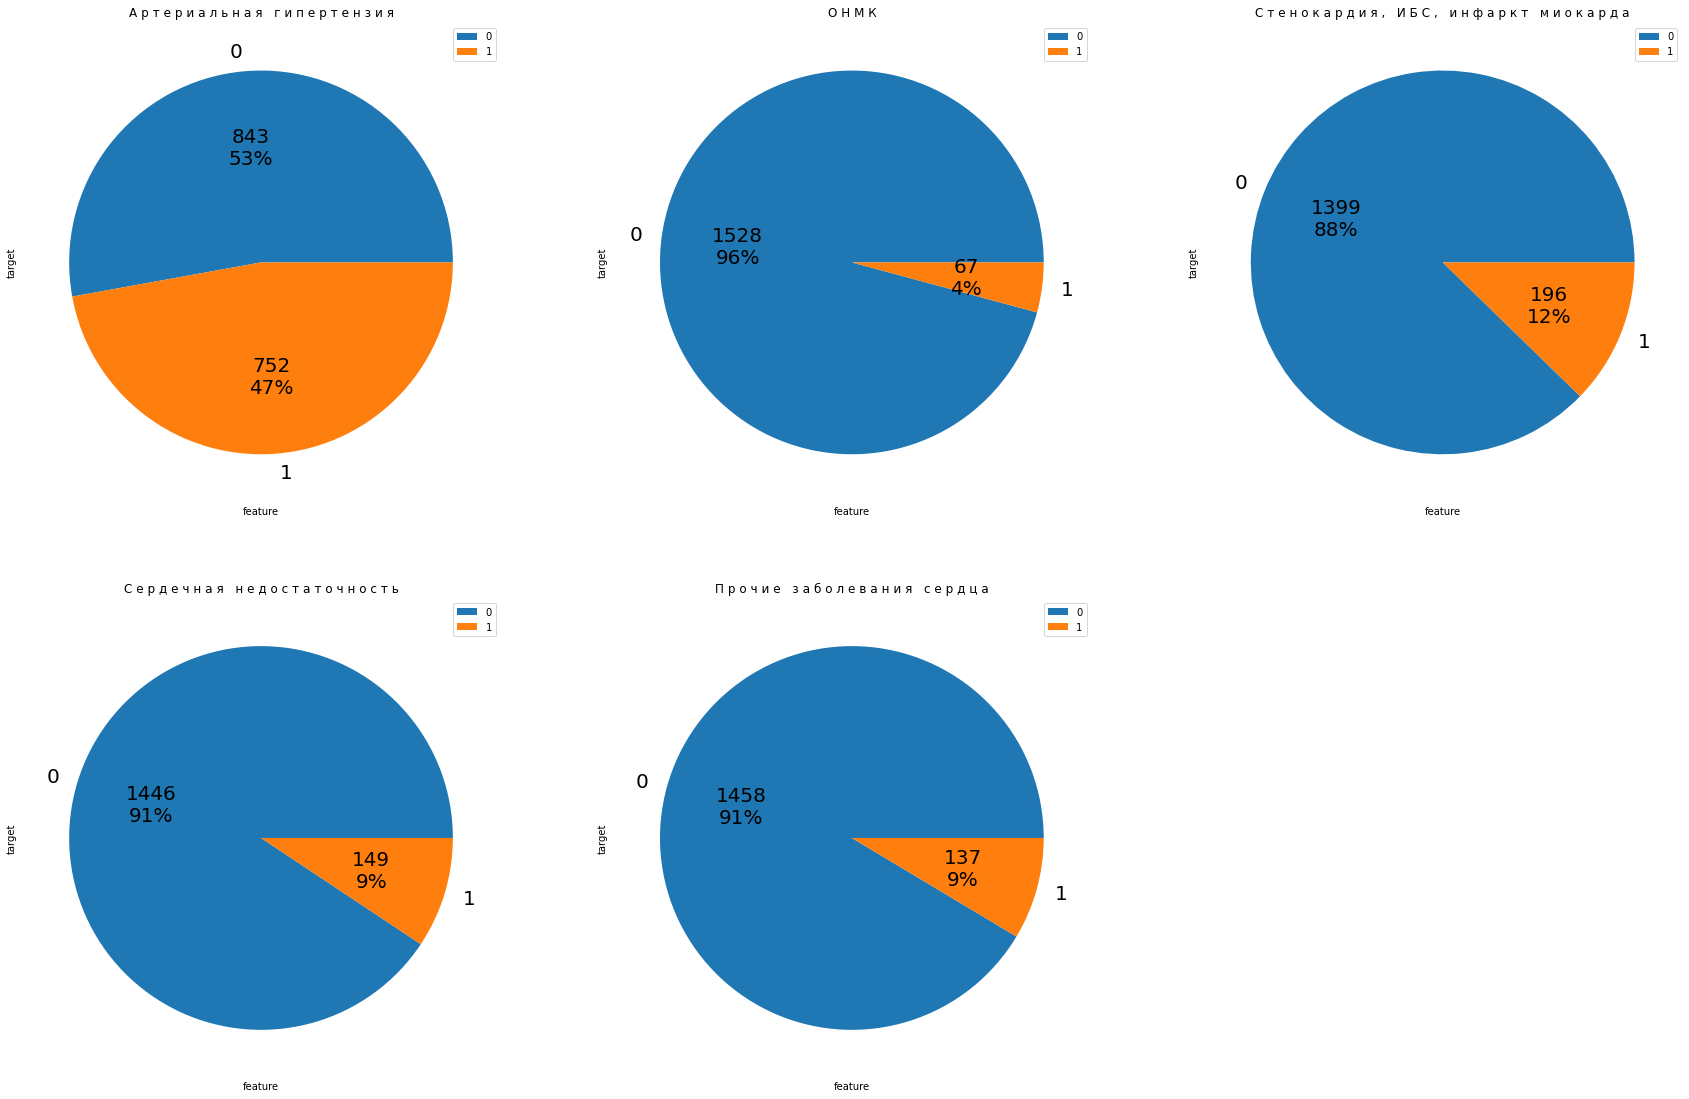

In [248]:
plt.figure(figsize=(30, 30))

def label_function(val):
    return f'{val / 100 * len(data_raw):.0f}\n{val:.0f}%'

for i, types in enumerate(res_cols):
    ax = plt.subplot(3, 3, i + 1)
    
    data_raw.groupby(types).size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20}, ax=ax)

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f09f8678d60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f09f6ab6460>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f09f8678a00>],
 'medians': [<matplotlib.lines.Line2D at 0x7f09f6ab6b20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f09f6ab6e80>],
 'means': []}

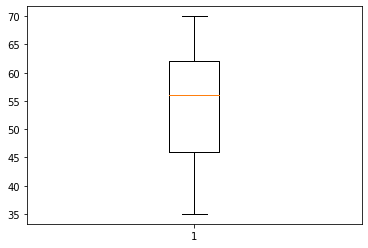

In [460]:
plt.boxplot(data_raw['Возраст'])

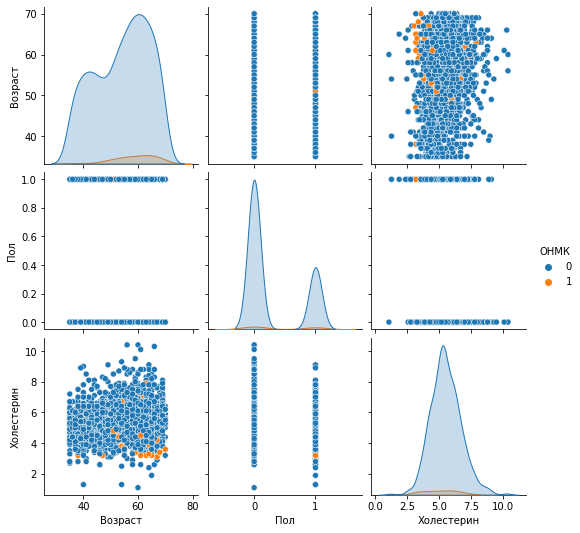

In [253]:
sns.pairplot(data_tiny, hue='ОНМК')

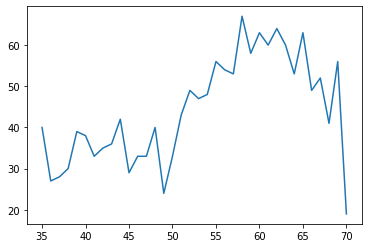

In [510]:
age_x = pd.Series(np.linspace(35,70,36))
plt.plot(age_x, data_raw['Возраст'].groupby(data_raw['Возраст']).count())

# Редактирование данных

In [917]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data_raw[['Статус Курения']])
tmp = enc.transform(data_raw[['Статус Курения']])
data_smoke = pd.DataFrame(tmp.toarray(), columns=['smoke_no_more', 'smoke', 'smoke_no1', 'smoke_no2'])
data_smoke = data_smoke.drop(['smoke_no1', 'smoke_no2'], axis=1)

In [948]:
data_raw = data_raw[data_raw['Возраст'] < 120]
data_raw = data_raw[data_raw['Глюкоза'] < 40]
data_raw['Место проживания 1-город 2-село'] = data_raw['Место проживания 1-город 2-село'].map({1:True, 2: False})
data_raw['Пол'] = data_raw['Пол'].map({'М':True, 'Ж': False})
data_raw['Достаток по срав с друг'] = data_raw['Достаток по срав с друг'].fillna('средний').map({'очень низкий':0, 
                                        'низкий': 1, 'средний': 2,'относительно высокий': 3,'очень высокий': 4,})

In [949]:
data_raw['smoke'] = data_smoke['smoke']
data_raw['smoke_no_more'] = data_smoke['smoke_no_more']
data_raw['Вес/рост'] = data_raw['Вес'] / data_raw['Рост']

In [1109]:
data_raw['Алкоголь'].unique()
data_raw['Алкоголь_no_more'] = data_raw['Алкоголь'] == 'ранее употреблял'
data_raw['Alcohol'] = data_raw['Алкоголь'] == 'употребляю в настоящее время'

In [950]:
modelLR = LogisticRegression()

In [1179]:
cols_temp = data_raw[['Возраст', 'Вес/рост', 'Глюкоза', 'Пол', 'Место проживания 1-город 2-село', 
                  'Достаток по срав с друг', 'Артериальная гипертензия']]

# Отбираем признаки, которые выглядят интересными, и строим модели

In [922]:
# for check in ['smoke_no_more', 'smoke']:
#     for res in res_cols:
#         print(check, res, scipy.stats.pearsonr(data[check], data[res]))
for check in check_data_cols4:
    for res in res_cols:
        print(check, res, scipy.stats.pearsonr(data_raw[check], data_raw[res]))

Достаток по срав с друг Артериальная гипертензия (-0.02898610627238556, 0.24743442450952385)
Достаток по срав с друг ОНМК (0.026158697237429907, 0.2966041013586593)
Достаток по срав с друг Стенокардия, ИБС, инфаркт миокарда (-0.022182775256224904, 0.37612433960755515)
Достаток по срав с друг Сердечная недостаточность (-0.014615134503636875, 0.5598383635857195)
Достаток по срав с друг Прочие заболевания сердца (0.008797951321854928, 0.7255967306889537)
smoke_no_more Артериальная гипертензия (0.014928388407185769, 0.551455517634193)
smoke_no_more ОНМК (-0.019430989949887883, 0.43819459900878055)
smoke_no_more Стенокардия, ИБС, инфаркт миокарда (0.03586784489225202, 0.15232753705979613)
smoke_no_more Сердечная недостаточность (0.016091541832053653, 0.520878864140422)
smoke_no_more Прочие заболевания сердца (0.01903717733712545, 0.4475352488611123)
smoke Артериальная гипертензия (-0.10873285717838926, 1.3573413011709536e-05)
smoke ОНМК (0.0292657395934839, 0.24290112353513635)
smoke Стенок

In [719]:
paramsRF = {'n_estimators':[50,550], 'max_depth':[3,10], 'criterion':['entropy', 'gini']}

CV_model = GridSearchCV(estimator=modelRF2, 
                        param_grid=paramsRF,
                        cv=5, 
                        scoring='roc_auc',
                        n_jobs=-1, 
                        verbose=False,
                        refit = True)
CV_model.fit(X_train, y_train)
CV_model.best_params_, CV_model.cv_results_['mean_test_score'], CV_model.best_score_

({'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 550},
 array([0.59109318, 0.59502037, 0.61636547, 0.62766047, 0.58410927,
        0.59338496, 0.61354682, 0.61465177]),
 0.627660469947704)

In [1151]:
x_art = data_raw[['Возраст', 'Вес/рост', 'Глюкоза', 'Пол', 'Место проживания 1-город 2-село', 
                  'Достаток по срав с друг']]
y_art = data_raw['Артериальная гипертензия']
x_ONMK = data_raw[['Возраст', 'Холестерин', 'Пол', 'smoke', 'Достаток по срав с друг', 'Alcohol']]
y_ONMK = data_raw['ОНМК']
x_steno = data_raw[['Возраст', 'Глюкоза', 'Место проживания 1-город 2-село', 'smoke', 'Достаток по срав с друг']]
y_steno = data_raw['Стенокардия, ИБС, инфаркт миокарда']
x_heart = data_raw[['Возраст', 'Глюкоза', 'Холестерин', 'Пол', 'smoke', 'Достаток по срав с друг']]
y_heart = data_raw[['Сердечная недостаточность']]
x_else = data_raw[['Возраст', 'Холестерин', 'Пол', 'Достаток по срав с друг']]
y_else = data_raw['Прочие заболевания сердца']

In [1116]:
#diff shit
x = data_raw[['Возраст', 'Вес/рост', 'Глюкоза', 'Пол', 'Место проживания 1-город 2-село', 
              'Достаток по срав с друг']]
y = data_raw['Артериальная гипертензия']

In [1117]:
X_train, X_test, y_train, y_test = train_test_split(x_art, y_art, test_size=0.25, random_state=30)

In [1189]:
# Артериальная гипертензия 0.7216017948976505
modelRF = RandomForestClassifier(random_state=1, max_depth=4, n_estimators=450, criterion='gini')
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=450, random_state=1)

In [1191]:
joblib.dump(modelRF, 'arter-modelRF.model')

['arter-modelRF.model']

In [1119]:
y_pred = modelRF.predict(X_test)

In [1120]:
print(roc_auc_score(y_test, y_pred))

0.7340083126362208


In [1192]:
# ОНМК 0.6653067885117493
X_train, X_test, y_train, y_test = train_test_split(x_ONMK, y_ONMK, test_size=0.25, random_state=30)

modelRF2 = RandomForestClassifier(random_state=0, max_depth=4, n_estimators=550, criterion='gini')
modelRF2.fit(X_train, y_train)
y_predRF = modelRF2.predict_proba(X_test)[:,0] < 0.93
np.sum(y_predRF)/y_predRF.shape[0]

0.05513784461152882

In [1160]:
print(roc_auc_score(y_test, y_predRF))

0.6162813870067756


In [1197]:
joblib.dump(modelRF2, 'ОНМК-modelRF.model')

['ОНМК-modelRF.model']

In [1194]:
# steno 0.714298433048433
X_train, X_test, y_train, y_test = train_test_split(x_steno, y_steno, test_size=0.25, random_state=30)

modelRF3 = RandomForestClassifier(random_state=0, max_depth=4, n_estimators=550, criterion='gini')
modelRF3.fit(X_train, y_train)
y_predRF = modelRF3.predict_proba(X_test)[:,0] < 0.91
np.sum(y_predRF)/y_predRF.shape[0]

0.5338345864661654

In [1158]:
print(roc_auc_score(y_test, y_predRF))

0.714298433048433


In [1196]:
joblib.dump(modelRF3, 'steno-modelRF.model')

['steno-modelRF.model']

In [1198]:
# heart 0.6967787114845939
X_train, X_test, y_train, y_test = train_test_split(x_heart, y_heart, test_size=0.25, random_state=30)

modelRF4 = RandomForestClassifier(random_state=0, max_depth=4, n_estimators=550, criterion='gini')
modelRF4.fit(X_train, y_train)
y_predRF = modelRF4.predict_proba(X_test)[:,0] < 0.91
np.sum(y_predRF)/y_predRF.shape[0]

<ipython-input-1198-4f43c4c4b0b6>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelRF4.fit(x_heart, y_heart)


0.42857142857142855

In [1156]:
print(roc_auc_score(y_test, y_predRF))

0.7051820728291316


In [1199]:
joblib.dump(modelRF4, 'heart-modelRF.model')

['heart-modelRF.model']

In [1152]:
# else 0.5363408521303258
X_train, X_test, y_train, y_test = train_test_split(x_else, y_else, test_size=0.25, random_state=30)

modelRF5 = RandomForestClassifier(random_state=0, max_depth=4, n_estimators=550, criterion='gini')
modelRF5.fit(X_train, y_train)
y_predRF = modelRF5.predict_proba(X_test)[:,0] >= 0.88
np.sum(y_predRF)/y_predRF.shape[0]

0.8696741854636592

In [1154]:
print(roc_auc_score(y_test, y_predRF))

0.5122442884873825


In [732]:
y_predRF.shape

(595,)

In [252]:
data_tiny = data_raw[['Возраст','Пол', 'Холестерин', 'ОНМК']]

In [ ]:
data

In [921]:
res_cols = ['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 
           'Сердечная недостаточность', 'Прочие заболевания сердца']
check_data_cols = ['Возраст','Вес', 'Глюкоза', 'Холестерин', 'Пол', 'Место проживания 1-город 2-село']
check_data_cols3 = ['Возраст','Вес', 'Глюкоза', 'Холестерин', 'Пол', 'Место проживания 1-город 2-село', 'Вес/рост']
check_data_cols2 = ['Вы работаете?', 'Сахарный диабет', 'Гепетит', 'Онкология', 'Хроническое заболевание легких',
                    'Бронжиальная астма', 'Туберкулез легких ', 'ВИЧ/СПИД', 'Регулярный прим лекарственных средств',
                   'Лекарство / давление', 'Лекарство / холестерин', 'Лекарство / инсульт', 'Лекарство / диабет']
check_data_cols4 = ['Достаток по срав с друг', 'smoke_no_more', 'smoke']

In [151]:
import scipy

In [1200]:
for check in check_data_cols3:
    for res in res_cols:
        print(check, res, scipy.stats.pearsonr(data_tiny[check], data_tiny[res]))

KeyError: 'Возраст'

In [1097]:
import torch
from torch import nn

In [1089]:
X = x_art.values
X

array([[63, 0.5308641975308642, 9.4, True, False, 2],
       [56, 0.49940476190476196, 4.9, False, False, 2],
       [60, 0.5282051282051282, 5.5, False, False, 2],
       ...,
       [45, 0.3965317919075144, 4.7, False, True, 1],
       [39, 0.4393063583815029, 4.5, False, True, 2],
       [50, 0.38833333333333336, 4.8, True, False, 2]], dtype=object)

In [1092]:
X = torch.FloatTensor(X.astype(np.float64))

In [1093]:
X.shape

torch.Size([1594, 6])

In [1099]:
model = nn.Sequential(
  nn.Linear(6, 64),
  nn.ReLU(),
  nn.Linear(64, 2)
)

In [1100]:
criterion = torch.nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) in its core, applied to logits

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))